In [3]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import utils.network as network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import utils.data as dt


# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Ball detector

Comparison between approaches.

Here im not sure about the ts


Im gonna do with 10 ts and add those results to the 20 and 100 ts . But does it make sense to equate computational power? I am gonna say that I had to do that due to computational limitations


So:

I am comparing the diferent approaches, and I am comparing 20 ts for 50 epochs to 100 ts for 25 epochs and also showing the training time. This way it would be clearer if the approach was undoubtly better.

In [2]:
# Train several models
dataset_folder = 'cropped_classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
batch_size = 50
quantization = 8
# all_num_steps = [20, 100]
print(f"TRAINING MODELS WITH QUANTIZATION {quantization}")
print("-"*50)
print("CREATING DATALOADERS")
print("-"*50)
labels = ['X', 'Y', 'Radius']
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization, labels=labels)
testset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
evalset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset_quant, batch_size=batch_size, shuffle=True)
evalloader = DataLoader(evalset_quant, batch_size=batch_size, shuffle=True)
inferenceloader = DataLoader(testset_quant, batch_size=1, shuffle=False)
img_shape_quant = trainset_quant.image_shape
bins_factor = trainset_quant.quantization / trainset_quant.label_quantization
models_numsteps = [
    (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN2LImageRegression(img_shape_quant), 20),
    # (network.SCNN2LImageRegression(img_shape_quant), 100),
    (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN3LImageRegression(img_shape_quant), 20),
    # (network.SCNN3LImageRegression(img_shape_quant), 100),
]
df = pd.DataFrame(columns=['Model', 'Num Steps', 'Error', 'Inference Time', 'Training Time'])

print("-"*50)
print("TRAINING MODELS")
print("-"*50)


for model, num_steps in models_numsteps:
    model_type = model.name
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training model {model_type} with {num_steps} time steps")
    # num_epochs = 25 if num_steps == 100 else 50
    num_epochs = 50
    print(f"Training for {num_epochs} epochs")
    model.to(device)
    start_train_time = time.perf_counter()
    model.start_training(trainloader, optimizer, device, 
                         validationloader=evalloader, 
                         num_steps=num_steps, num_epochs=num_epochs, plot=False)
    training_time = time.perf_counter() - start_train_time
    save_path = f'models/{model_type}_q{quantization}_{num_steps}ts_{num_epochs}e.pt'
    # torch.save({
    #     'model_state_dict': model.state_dict(),
    #     'training_params': model.training_params,
    # }, save_path)
    error = model.evaluate(testloader, device, num_steps=num_steps, print_results=False) # I am evaluating all models with 20 time steps for better comparison
    error = np.linalg.norm(error).item()
    inference_time = network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=num_steps, num_batches=5)

    new_row = pd.DataFrame({
        'Model': [model_type],
        'Num Steps': [num_steps],
        'Error': [error],
        'Inference Time': [inference_time],
        'Training Time': [training_time]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    print(f"Model {model_type} with {num_steps} time steps: Error={error:.4f}, Inference Time={inference_time:.6f} sec/image, Training Time={training_time:.2f} sec")
    print("-"*50)
    del model
    torch.cuda.empty_cache()
    

df.to_csv(f'models/q{quantization}_results.csv', index=False)

TRAINING MODELS WITH QUANTIZATION 8
--------------------------------------------------
CREATING DATALOADERS
--------------------------------------------------
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Flattened feature size: 8064

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_23484\1836292822.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Epoch 1/50, Loss: 2527.1265, Validation Error: 35.5679 pixels
Epoch 2/50, Loss: 1040.1923, Validation Error: 19.8574 pixels
Epoch 3/50, Loss: 335.8372, Validation Error: 12.6846 pixels
Epoch 4/50, Loss: 171.1183, Validation Error: 9.2564 pixels
Epoch 5/50, Loss: 101.3706, Validation Error: 7.8981 pixels
Epoch 6/50, Loss: 71.2026, Validation Error: 6.8723 pixels
Epoch 7/50, Loss: 169.0764, Validation Error: 10.2634 pixels
Epoch 8/50, Loss: 87.5408, Validation Error: 5.4254 pixels
Epoch 9/50, Loss: 44.4160, Validation Error: 5.1743 pixels
Epoch 10/50, Loss: 31.8541, Validation Error: 4.8936 pixels
Epoch 11/50, Loss: 29.7555, Validation Error: 4.6719 pixels
Epoch 12/50, Loss: 22.6618, Validation Error: 4.5085 pixels
Epoch 13/50, Loss: 20.5741, Validation Error: 4.1294 pixels
Epoch 14/50, Loss: 17.7088, Validation Error: 3.8487 pixels
Epoch 15/50, Loss: 16.2722, Validation Error: 3.7848 pixels
Epoch 16/50, Loss: 14.5040, Validation Error: 3.5374 pixels
Epoch 17/50, Loss: 13.5329, Validatio

In [3]:
# Train several models
dataset_folder = 'cropped_classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
batch_size = 50
quantization = 4
# all_num_steps = [20, 100]
print(f"TRAINING MODELS WITH QUANTIZATION {quantization}")
print("-"*50)
print("CREATING DATALOADERS")
print("-"*50)
labels = ['X', 'Y', 'Radius']
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization, labels=labels)
testset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
evalset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset_quant, batch_size=batch_size, shuffle=True)
evalloader = DataLoader(evalset_quant, batch_size=batch_size, shuffle=True)
inferenceloader = DataLoader(testset_quant, batch_size=1, shuffle=False)
img_shape_quant = trainset_quant.image_shape
bins_factor = trainset_quant.quantization / trainset_quant.label_quantization
models_numsteps = [
    (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN2LImageRegression(img_shape_quant), 20),
    # (network.SCNN2LImageRegression(img_shape_quant), 100),
    (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN3LImageRegression(img_shape_quant), 20),
    # (network.SCNN3LImageRegression(img_shape_quant), 100),
]
df = pd.DataFrame(columns=['Model', 'Num Steps', 'Error', 'Inference Time', 'Training Time'])

print("-"*50)
print("TRAINING MODELS")
print("-"*50)


for model, num_steps in models_numsteps:
    model_type = model.name
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training model {model_type} with {num_steps} time steps")
    # num_epochs = 25 if num_steps == 100 else 50
    num_epochs = 50
    print(f"Training for {num_epochs} epochs")
    model.to(device)
    start_train_time = time.perf_counter()
    model.start_training(trainloader, optimizer, device, 
                         validationloader=evalloader, 
                         num_steps=num_steps, num_epochs=num_epochs, plot=False)
    training_time = time.perf_counter() - start_train_time
    save_path = f'models/{model_type}_q{quantization}_{num_steps}ts_{num_epochs}e.pt'
    # torch.save({
    #     'model_state_dict': model.state_dict(),
    #     'training_params': model.training_params,
    # }, save_path)
    error = model.evaluate(testloader, device, num_steps=num_steps, print_results=False) # I am evaluating all models with 20 time steps for better comparison
    error = np.linalg.norm(error).item()
    inference_time = network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=num_steps, num_batches=5)

    new_row = pd.DataFrame({
        'Model': [model_type],
        'Num Steps': [num_steps],
        'Error': [error],
        'Inference Time': [inference_time],
        'Training Time': [training_time]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    print(f"Model {model_type} with {num_steps} time steps: Error={error:.4f}, Inference Time={inference_time:.6f} sec/image, Training Time={training_time:.2f} sec")
    print("-"*50)
    del model
    torch.cuda.empty_cache()
    

df.to_csv(f'models/q{quantization}_results.csv', index=False)

TRAINING MODELS WITH QUANTIZATION 4
--------------------------------------------------
CREATING DATALOADERS
--------------------------------------------------
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Flattened featur

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_23484\2415557250.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Epoch 1/50, Loss: 10060.5397, Validation Error: 71.2925 pixels
Epoch 2/50, Loss: 4052.5077, Validation Error: 40.2080 pixels
Epoch 3/50, Loss: 1241.4938, Validation Error: 21.4229 pixels
Epoch 4/50, Loss: 433.9808, Validation Error: 15.7075 pixels
Epoch 5/50, Loss: 229.4964, Validation Error: 12.2805 pixels
Epoch 6/50, Loss: 178.2405, Validation Error: 10.8023 pixels
Epoch 7/50, Loss: 129.1512, Validation Error: 10.7056 pixels
Epoch 8/50, Loss: 135.0944, Validation Error: 9.3465 pixels
Epoch 9/50, Loss: 85.8630, Validation Error: 8.9634 pixels
Epoch 10/50, Loss: 80.4507, Validation Error: 8.7983 pixels
Epoch 11/50, Loss: 90.2515, Validation Error: 8.3812 pixels
Epoch 12/50, Loss: 76.6829, Validation Error: 7.9525 pixels
Epoch 13/50, Loss: 70.5202, Validation Error: 6.8341 pixels
Epoch 14/50, Loss: 69.8876, Validation Error: 7.6801 pixels
Epoch 15/50, Loss: 65.7047, Validation Error: 6.9085 pixels
Epoch 16/50, Loss: 64.2353, Validation Error: 8.8982 pixels
Epoch 17/50, Loss: 66.6888, Va

Maybe add the weighted average thing and do it for the 2D Ball detector. If I do it for the image tracker, i need to train a new model...

In [1]:
model1 = network.load_model('models/VideoTrackerClassWAvg_q8_10ts_50e.pt', network.SCNN_Video_Tracker_Class, device)
network.plot_timestep_curve(model1, testloader, device, identifier="T: WAvg, I: WAvg", regression=True, interval = [1, 20, 1])
model1.weighted_avg = False
network.plot_timestep_curve(model1, testloader, device, identifier="T: WAvg, I: No WAvg", regression=True, interval = [1, 20, 1])
model2 = network.load_model('models/VideoTrackerClass_q8_10ts_30e.pt', network.SCNN_Video_Tracker_Class, device)
network.plot_timestep_curve(model2, testloader, device, identifier="T: No WAvg, I: No WAvg", regression=True, interval = [1, 20, 1])
model2.weighted_avg = True
network.plot_timestep_curve(model2, testloader, device, identifier="T: No WAvg, I: WAvg", regression=True, interval = [1, 20, 1])
plt.legend()

NameError: name 'network' is not defined

# 3D Ball Tracker

Motivate timesteps

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

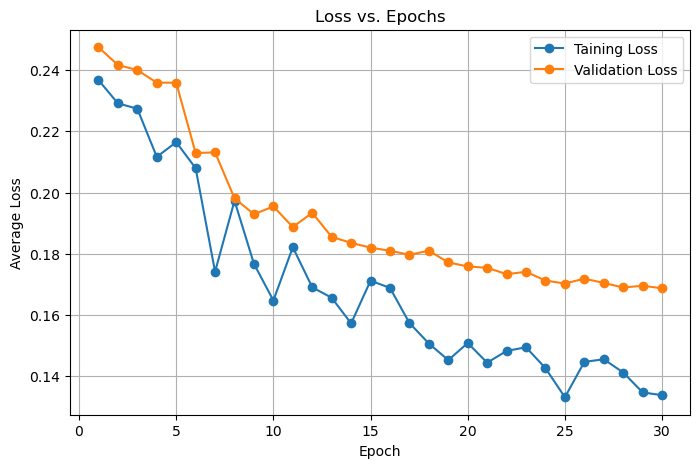

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Error for x_cam: 4.4603 pixels
Average Error for y_cam: 1.1969 pixels
Average Error for R_cam: 0.5166 pixels
Best model error: 4.646941254224549
Model saved at models/VideoClassification_q8_1ts_30e.pt
Training with num_steps=2
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2278, Validation Loss: 0.2501 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2196, Validation Loss: 0.2388 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/30, Training Loss: 0.2242, Validation Loss: 0.2215 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1874, Validation Loss: 0.2133 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/30, Training Loss: 0.1731, Validation Loss: 0.1976 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/30, Training Loss: 0.1768, Validation Loss: 0.1936 pixe

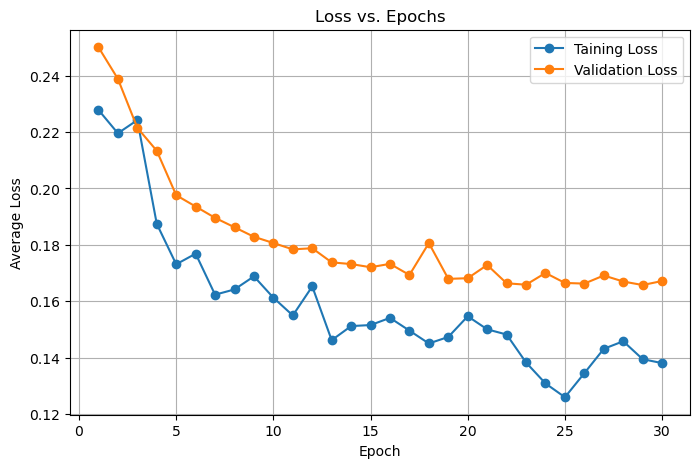

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.7331 pixels
Average Error for y_cam: 0.9872 pixels
Average Error for R_cam: 0.4703 pixels
Best model error: 2.049272397775702
Model saved at models/VideoClassification_q8_2ts_29e.pt
Training with num_steps=5
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2300, Validation Loss: 0.2407 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2279, Validation Loss: 0.2423 pixels
Epoch 3/30, Training Loss: 0.2109, Validation Loss: 0.2231 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.2042, Validation Loss: 0.2024 pixels
Model saved at models/best_model_current_training.p

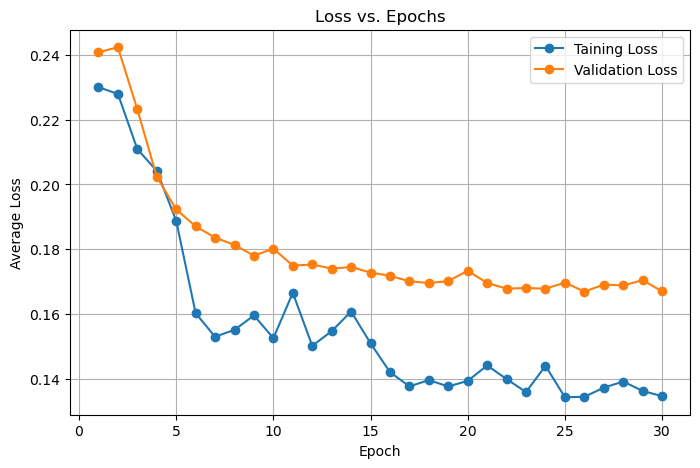

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.7514 pixels
Average Error for y_cam: 0.9245 pixels
Average Error for R_cam: 0.4631 pixels
Best model error: 2.0338295561565225
Model saved at models/VideoClassification_q8_5ts_26e.pt
Training with num_steps=10
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2275, Validation Loss: 0.2402 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2244, Validation Loss: 0.2482 pixels
Epoch 3/30, Training Loss: 0.2181, Validation Loss: 0.2153 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1901, Validation Loss: 0.2074 pixels
Model saved at models/best_model_current_training

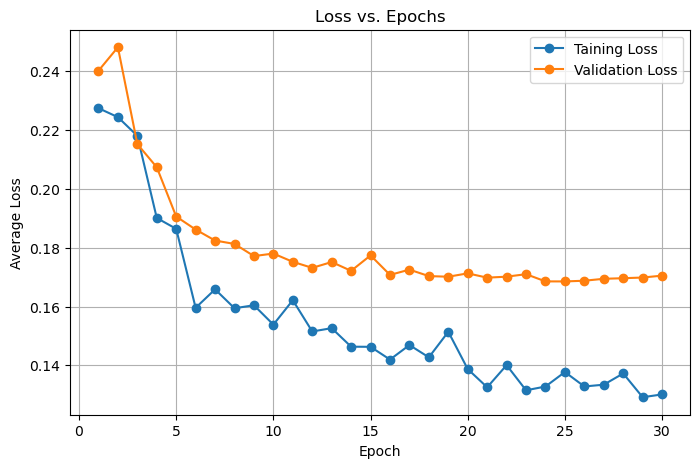

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.3700 pixels
Average Error for y_cam: 1.0741 pixels
Average Error for R_cam: 0.4779 pixels
Best model error: 1.8052950918364563
Model saved at models/VideoClassification_q8_10ts_25e.pt
Training with num_steps=20
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2346, Validation Loss: 0.2378 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2188, Validation Loss: 0.2578 pixels
Epoch 3/30, Training Loss: 0.1868, Validation Loss: 0.2073 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1773, Validation Loss: 0.1912 pixels
Model saved at models/best_model_current_trainin

In [ ]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [1, 2, 5, 10, 20, 50]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 30

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


Text(0.5, 1.0, 'Validation Losses for Different Models')

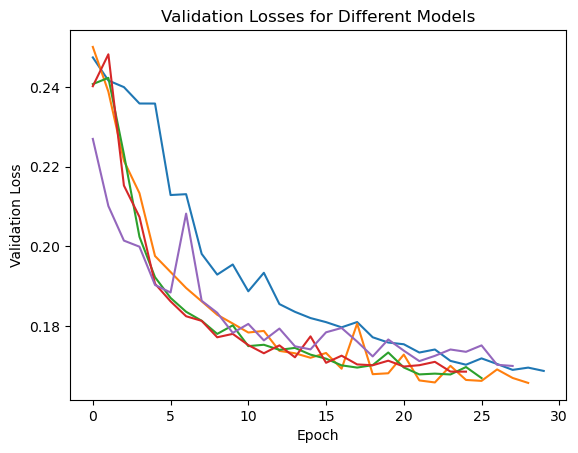

In [ ]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


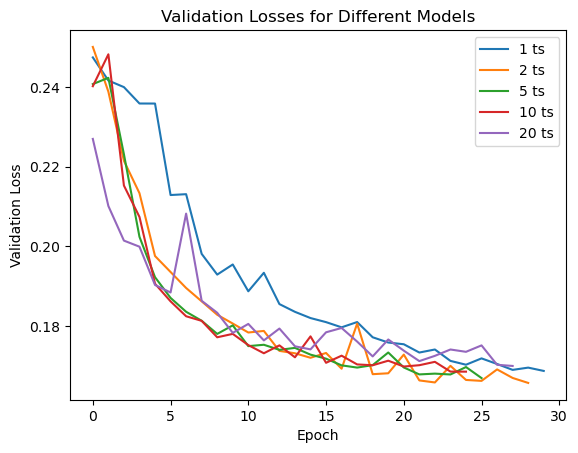

In [8]:

models = [
    'models/VideoClassification_q8_1ts_30e.pt',
    'models/VideoClassification_q8_2ts_29e.pt',
    'models/VideoClassification_q8_5ts_26e.pt',
    'models/VideoClassification_q8_10ts_25e.pt',
    'models/VideoClassification_q8_20ts_28e.pt'
]

for model_path in models:
    model = network.load_model(model_path, network.SCNNVideoClassification, trainset_in, device)
    val_losses = model.training_params['validation_losses']
    plt.plot(val_losses, label=str(model.training_params['num_steps']) + ' ts')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Losses for Different Models')
plt.legend()
plt.show()
    

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

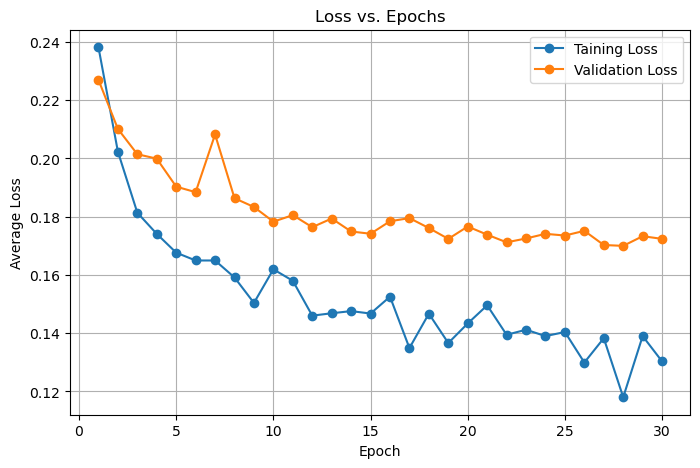

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Error for x_cam: 1.6503 pixels
Average Error for y_cam: 1.2572 pixels
Average Error for R_cam: 0.4407 pixels
Best model error: 2.1209670690434366
Model saved at models/VideoClassification_q8_20ts_28e.pt
Training with num_steps=50
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2162, Validation Loss: 0.2272 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2089, Validation Loss: 0.2127 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/30, Training Loss: 0.1892, Validation Loss: 0.2042 pixels
Model saved at models/best_model_current_training.pt


KeyboardInterrupt: 

In [3]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [20, 50]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 30

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

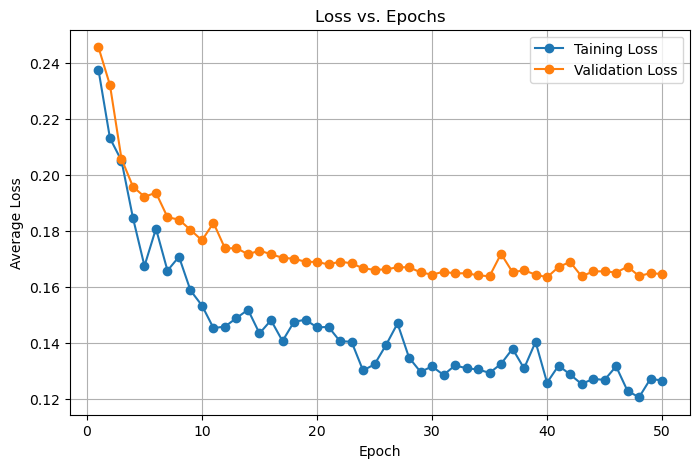

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Error for x_cam: 2.0445 pixels
Average Error for y_cam: 0.8083 pixels
Average Error for R_cam: 0.3869 pixels
Best model error: 2.2322429440445375
Model saved at models/VideoClassification_q8_2ts_40e.pt
Training with num_steps=5
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/50, Training Loss: 0.2507, Validation Loss: 0.2944 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/50, Training Loss: 0.2236, Validation Loss: 0.2249 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/50, Training Loss: 0.1877, Validation Loss: 0.2046 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/50, Training Loss: 0.1788, Validation Loss: 0.1938 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/50, Training Loss: 0.1821, Validation Loss: 0.1880 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/50, Training Loss: 0.1729, Validation Loss: 0.2059 pix

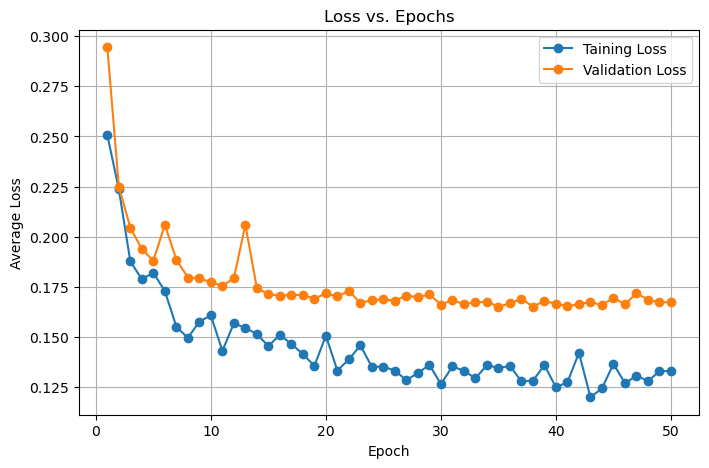

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.4983 pixels
Average Error for y_cam: 0.8310 pixels
Average Error for R_cam: 0.4600 pixels
Best model error: 1.7739923535326723
Model saved at models/VideoClassification_q8_5ts_38e.pt


In [2]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [2, 5]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 50

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

In [28]:
dataloader = valid_loader_in

In [29]:
model = network.load_model('models/VideoClassification_q8_5ts_26e.pt', network.SCNNVideoClassification, testset_in, device)
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True)
print(f'Error: {np.linalg.norm(error)}')
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, weighted_avg=True)
print(f'Error: {np.linalg.norm(error)}')

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 1.7514 pixels
Average Error for y_cam: 0.9245 pixels
Average Error for R_cam: 0.4631 pixels
Error: 2.0338295561565225
Evaluating video regression tracker
Average Error for x_cam: 16.2661 pixels
Average Error for y_cam: 7.4748 pixels
Average Error for R_cam: 16.3035 pixels
Error: 24.212933883699534


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Error 0: μ=1.37, σ=5.37, 95% CI=10.204 pixels
Error 1: μ=1.07, σ=3.60, 95% CI=6.997 pixels
Error 2: μ=0.48, σ=1.40, 95% CI=2.785 pixels
Total errors: σ=4.85, 95% CI=11.870 pixels
Evaluating video regression tracker
Error 0: μ=16.25, σ=9.50, 95% CI=31.872 pixels
Error 1: μ=7.17, σ=5.44, 95% CI=16.109 pixels
Error 2: μ=15.58, σ=7.85, 95% CI=28.493 pixels
Total errors: σ=19.23, 95% CI=47.067 pixels


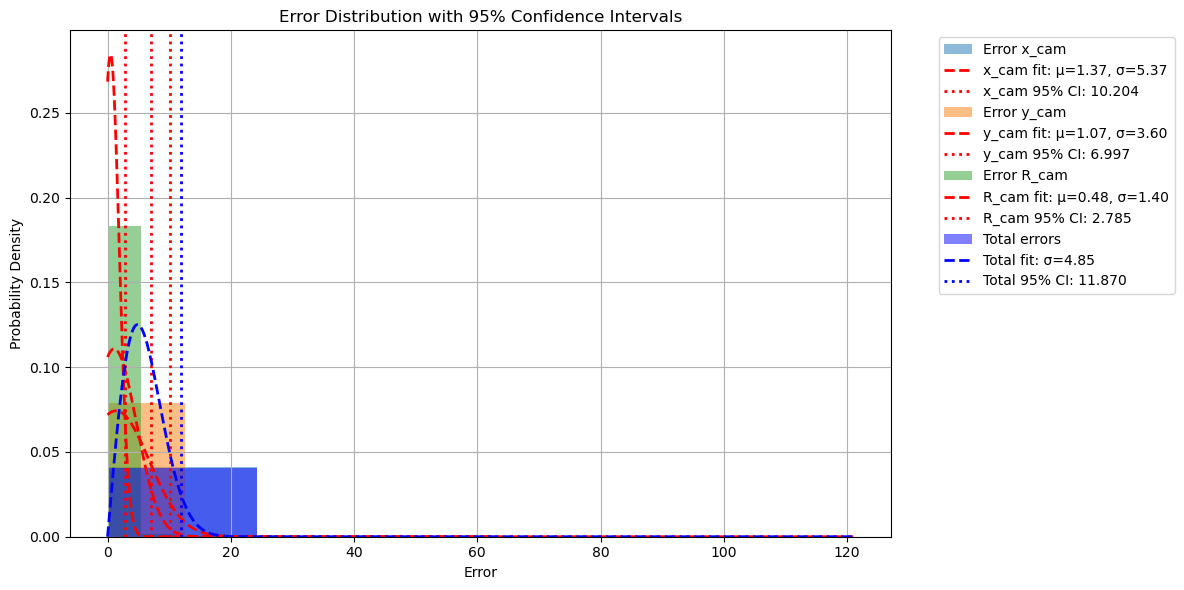

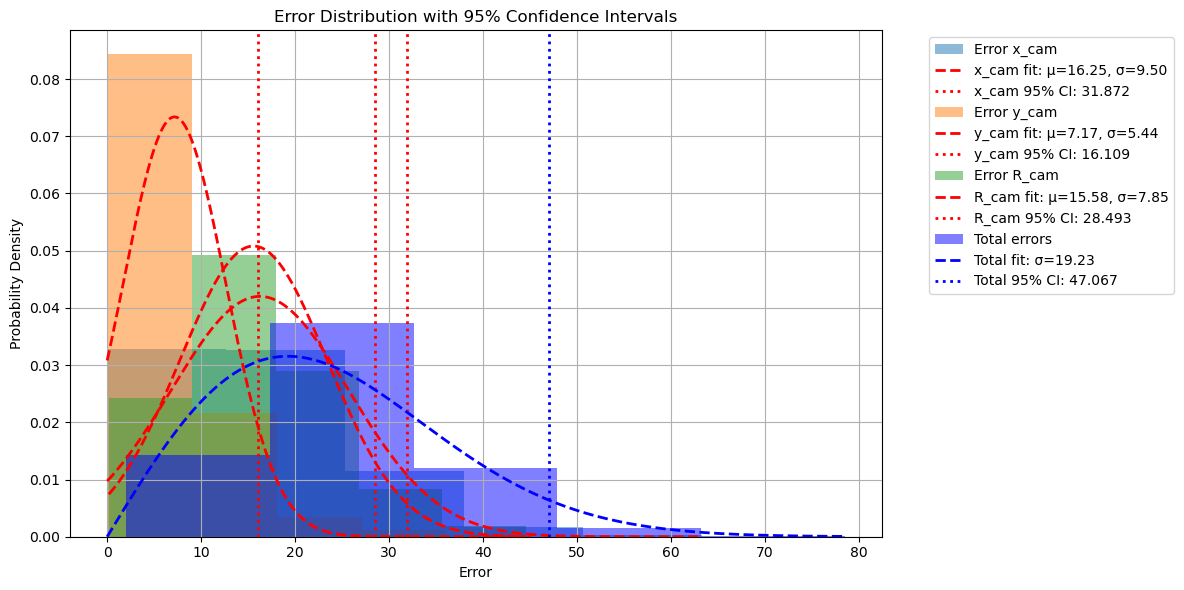

In [34]:
model1 = network.load_model('models/VideoClassification_q8_10ts_25e.pt', network.SCNNVideoClassification, testset_in, device)
error = model1.evaluate(dataloader, device, num_steps=model1.training_params["num_steps"], print_results=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')
error = model1.evaluate(dataloader, device, num_steps=model1.training_params["num_steps"], print_results=True, weighted_avg=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = model_class(trainset, w

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Error 0: μ=1.62, σ=6.74, 95% CI=12.707 pixels
Error 1: μ=0.82, σ=1.53, 95% CI=3.335 pixels
Error 2: μ=0.49, σ=1.31, 95% CI=2.633 pixels
Total errors: σ=5.15, 95% CI=12.601 pixels
Evaluating video regression tracker
Error 0: μ=1.73, σ=4.98, 95% CI=9.912 pixels
Error 1: μ=0.75, σ=1.37, 95% CI=3.015 pixels
Error 2: μ=0.61, σ=1.27, 95% CI=2.700 pixels
Total errors: σ=4.01, 95% CI=9.820 pixels


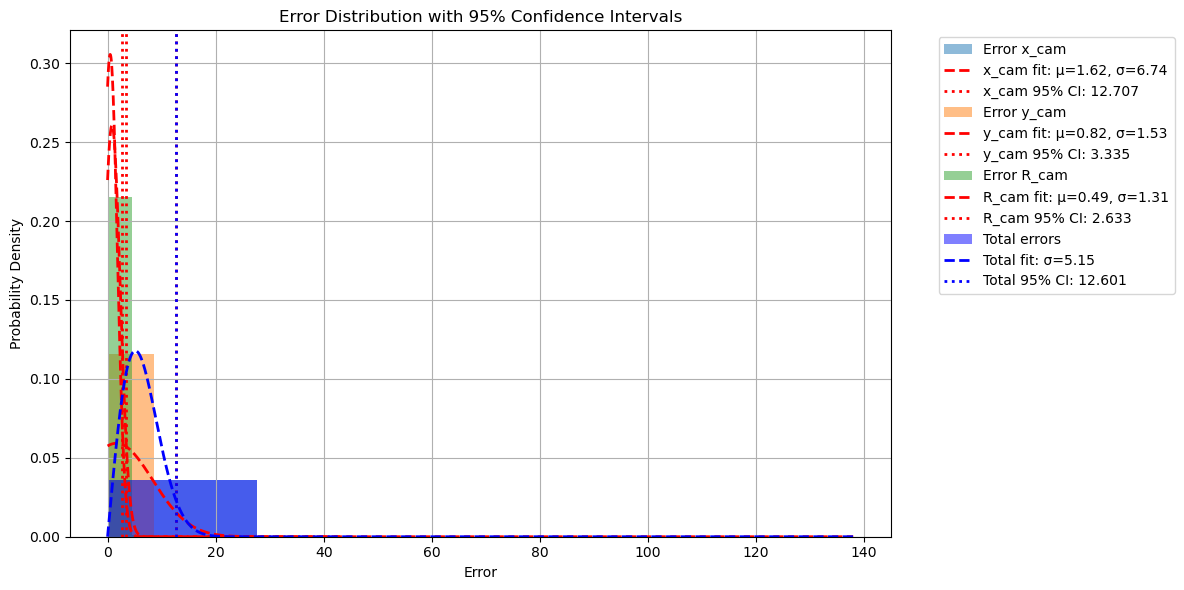

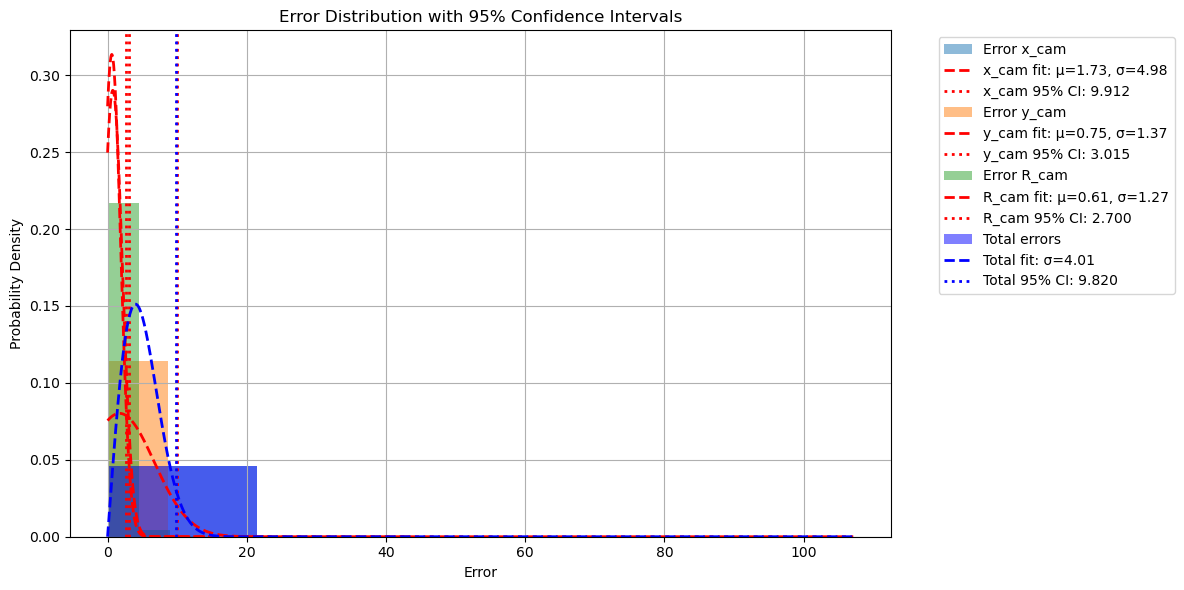

In [37]:
model = network.load_model('models/BEST-VideoClassification-all_lt_aug_q8_10ts_30e.pt', network.SCNNVideoClassification, testset_in, device)
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, weighted_avg=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')

## Kalman Stuff

Results depending on cutoff time

Results depending on distance to the goal

# Exploring Q4

In [3]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 4
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [5]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 50

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=10) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 180, 320])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 180, 320])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 180, 320])
Number of label f

KeyboardInterrupt: 

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

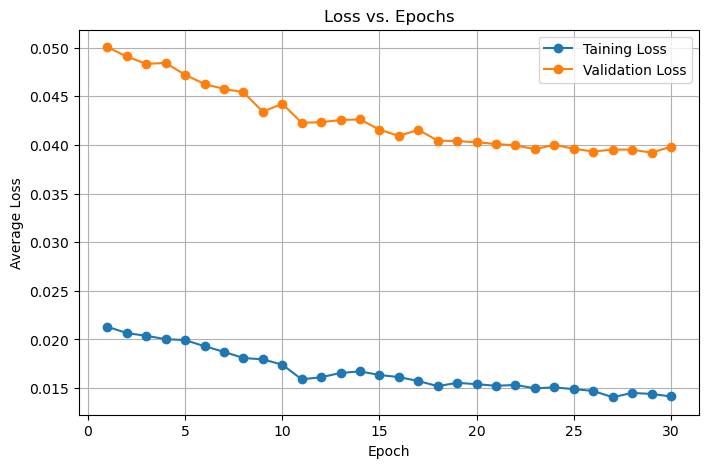

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2430: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Average Error for x_cam: -3.3552 pixels
Average Error for y_cam: -2.3448 pixels
Average Error for R_cam: 0.1928 pixels
Best model error: 4.097871913709026
Model saved at models/CNNVideoClassification_q8_0ts_29e.pt


In [ ]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 55
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
model.name += f'-{dataset_type}_aug'
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=3e-2)
num_epochs = 30

# def lr_lambda(step):
#     warmup_steps = 2 * length_train          # 1 epoch
#     return min(1.0, step / warmup_steps)

# warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer,
#                 T_max = num_epochs*len(trainloader_in),  # full schedule
#                 eta_min = 1e-5)
loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs)
network.save_best_model(network.CNNVideoClassification, valid_loader_in, device, evaluate=True)